In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !cp "/content/drive/MyDrive/Colab Notebooks/Datasets/Data.zip" "/content/Data"
# !unzip "/content/Data/Data.zip" -d "/content/Data/"

In [3]:
# !pip install tensorflow-addons

# !pip install -q -U albumentations
# !echo "$(pip freeze | grep albumentations) is successfully installed"

# Problem Statement
***Cassava Leaf Disease Classification***

**Background:-**
* Cassava is the second-largest provider of carbohydrates in Africa.
* Cassava is a key food security crop grown by smallholder farmers because it can withstand harsh conditions.
* **Viral Diseases** are major sources of poor yields of this crop.  

**Necessity:-**
* Existing methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants.
* This makes it highly manual and labour intensive.
* It maybe possible to identify type of disease using Computer Vision, so they can be treated and a yields can be improved.
* While creating the model we need to keep in mind that farmers of Africa might not have a high-end camera to provide crisp images to the pipeline all the time.  

**Data Description:-**
* Set of 21,367 labeled images collected during a regular survey in Uganda.
* Most images crowdsourced from farmers taking photos of their gardens.
* Annotated by experts at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab at Makerere University, Kampala.
* This is in a format that most realistically represents what farmers would need to diagnose in real life.

**Expected Outcome:-**  
Classify each cassava image into four disease categories or a fifth category indicating a healthy leaf.

**Problem Category:-**  
As inferred from the problem statement this problem is clearly a **Supervised - Muti class classification** problem. And as it revolves around identifying classes from *images* it falls under the umbrella of **Computer Vision**.

# EDA
Let's start with some standard imports and data location pointers to take us through this exercise.

In [4]:
# For Reproducable results
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

# Asthetics
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# General
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import os
import time
import cv2

# Visialisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from PIL import Image

# Deep Learning
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow_addons.callbacks import TQDMProgressBar
# Augmentation
import albumentations

#Metrics
from sklearn import metrics, model_selection, preprocessing
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
print(tf.__version__)

2.4.1


In [6]:
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)
# AUTOTUNE = tf.data.experimental.AUTOTUNE

In [7]:
data_path = '/content/Data'

labels_file_path = os.path.join(data_path, 'train.csv')
label_to_class_json_path = os.path.join(data_path, 'label_num_to_disease_map.json')
train_images_path = os.path.join(data_path, 'train_images')
test_images_path = os.path.join(data_path, 'test_images')

print(f'Label File path: {labels_file_path}')
print(f'Json File path: {label_to_class_json_path}')
print(f'Train Images path: {train_images_path}')
print(f'Test Images path: {test_images_path}')

Label File path: /content/Data/train.csv
Json File path: /content/Data/label_num_to_disease_map.json
Train Images path: /content/Data/train_images
Test Images path: /content/Data/test_images


In [8]:
labels_df = pd.read_csv(labels_file_path)
labels_df['label_str'] = labels_df['label'].astype('string')
labels_df.head()

,image_id,label,label_str
0,1000015157.jpg,0,0
1,1000201771.jpg,3,3
2,100042118.jpg,1,1
3,1000723321.jpg,1,1
4,1000812911.jpg,3,3


In [9]:
label_to_class_dict = pd.read_json(label_to_class_json_path, orient='index').to_dict()[0]
print(f'We have {len(label_to_class_dict)} classes to predict.\nVarious classes are:-')
for i, label in enumerate(label_to_class_dict):
    print(f'  {i+1}. {label_to_class_dict[label]} ({label})')

We have 5 classes to predict.
Various classes are:-
  1. Cassava Bacterial Blight (CBB) (0)
  2. Cassava Brown Streak Disease (CBSD) (1)
  3. Cassava Green Mottle (CGM) (2)
  4. Cassava Mosaic Disease (CMD) (3)
  5. Healthy (4)


From the data, we can see that we have to predict the disease from one of **5 different classes**.  
The various classes are:-  
1. Cassava Bacterial Blight (CBB)
2. Cassava Brown Streak Disease (CBSD)
3. Cassava Green Mottle (CGM)
4. Cassava Mosaic Disease (CMD)
5. Healthy  

Not let's see how many examples we have for each class.

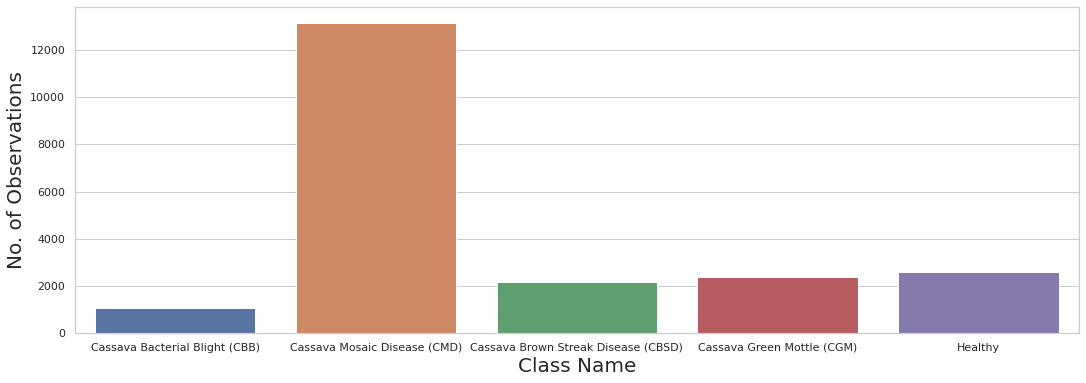

In [10]:
labels_df_temp = labels_df
labels_df_temp['Class Name'] = labels_df_temp['label'].map(label_to_class_dict)
ax = plt.subplots(figsize=(18, 6))
sns.set_style("whitegrid")
sns.countplot(x='Class Name', data=labels_df_temp);
plt.ylabel("No. of Observations", size=20);
plt.xlabel("Class Name", size=20);

We can see that we are dealing with a highly imbalanced classification problem. So we might need to add some transformed/augmented images to the lowly populated classes to slightly balance the problem.  
Now let's see some examples of each of the classes:-

In [11]:
def show_image(class_num, examples=2, labels_df=labels_df, label_to_class_dict=label_to_class_dict,
               train_images_path=train_images_path):
    image_list = labels_df[labels_df['label'] == class_num]['image_id'].sample(frac=1)[:examples].to_list()
    plt.figure(figsize=(20,10))
    for i, img in enumerate(image_list):
        full_path = os.path.join(train_images_path, img)
        img = Image.open(full_path)
        plt.subplot(1 ,examples, i%examples +1)
        plt.axis('off')
        plt.imshow(img)
        plt.title(label_to_class_dict[class_num])

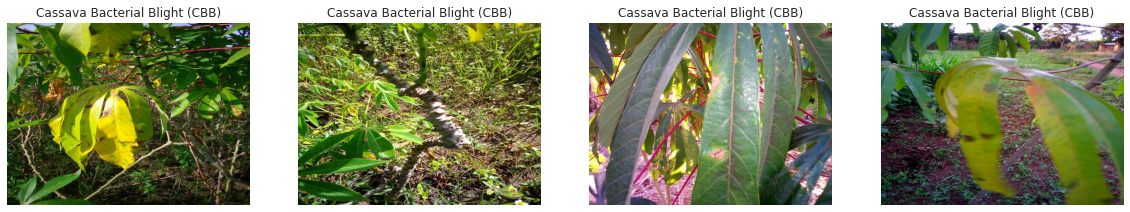

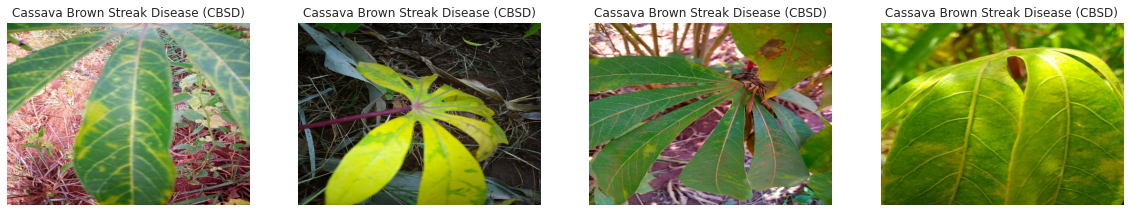

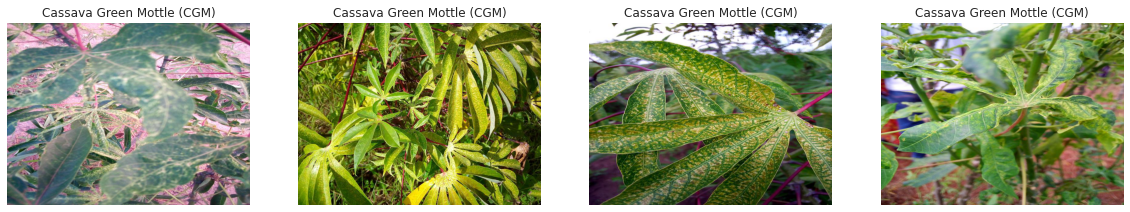

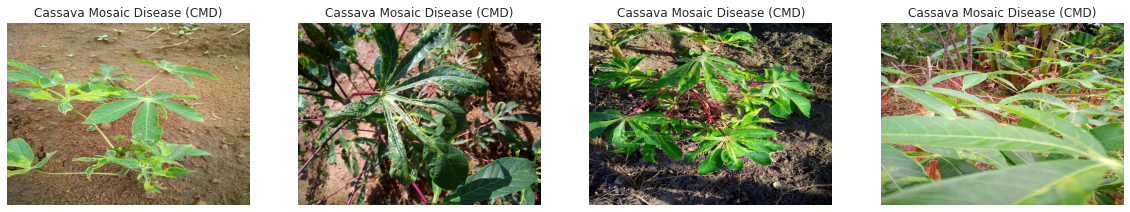

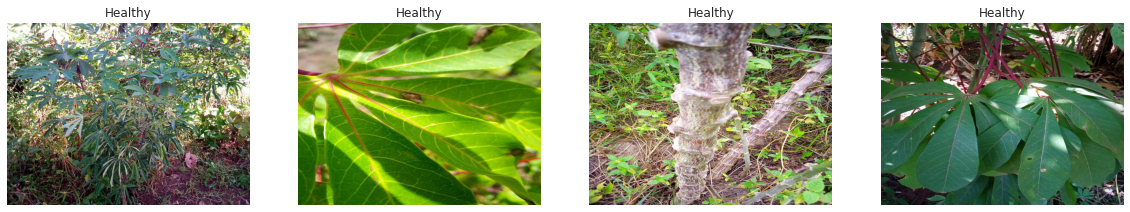

In [12]:
for lab in label_to_class_dict.keys():
    show_image(lab, examples=4)

# Model Creation

As we can see, from the examples above, there are certain clases that can be confused amongst themselves as the difference is not so apparent. We have got a difficult yet exciting problem on our hands.  
Since the complexity and level of difficulty is high, let's start right off with Deep-Learning, transfer learning and [**MobileNet V2**](https://arxiv.org/abs/1801.04381) by [Google](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html). Because manual shallow NN and primitive transfer learning models like LeNet will have a difficult time learning on this dataset.

In [13]:
TEST_SIZE = 0.1
BATCH = 16
IMG_DIM = 299
RANDOM_SEED = 42
EPOCHS = 40
start_LR = 0.0001
min_lr_per = 0.001
Decay_after = 10
PERCENT_LAYERS_TO_FINE_TUNE = 0.2

In [14]:
#Train-Valid Split of training dataset
df_train, df_valid = model_selection.train_test_split(labels_df,
                                                      test_size=TEST_SIZE,
                                                      random_state=RANDOM_SEED,
                                                      stratify=labels_df.label.values)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

Now let's define some augmentations of the image to make the model more genralised and help with the training dataset size.

In [15]:
def train_transform(image, IMG_DIM=IMG_DIM):
  train_aug = albumentations.Compose([albumentations.RandomResizedCrop(IMG_DIM, IMG_DIM, p=0.5),
                                      albumentations.Transpose(p=0.5),
                                      albumentations.HorizontalFlip(p=0.5),
                                      albumentations.VerticalFlip(p=0.5),
                                      albumentations.ShiftScaleRotate(shift_limit=0.2, rotate_limit=180, scale_limit=0.1, p=0.5),
                                      albumentations.HueSaturationValue(hue_shift_limit=[0.1, 0.2],
                                                                        sat_shift_limit=[0, 0],
                                                                        val_shift_limit=[0, 0],
                                                                        p=1.),
                                      albumentations.RandomBrightnessContrast(brightness_limit=[0.1,0.1],
                                                                              contrast_limit=[1, 1],
                                                                              p=0.5),
                                      albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225],
                                                              max_pixel_value=255.0,
                                                              p=1.0),
                                      albumentations.CoarseDropout(max_holes=8, max_height=30, max_width=30, p=0.5)],
                                    p=1.)
  return train_aug(image=image)['image']

In [16]:
def valid_transform(image, IMG_DIM=IMG_DIM):
  valid_aug = albumentations.Compose([albumentations.Resize(IMG_DIM, IMG_DIM, interpolation=1, p=1.),
                                      albumentations.Normalize(mean=[0.485, 0.456, 0.406], 
                                                               std=[0.229, 0.224, 0.225], 
                                                               max_pixel_value=255.0, 
                                                               p=1.0)],
                                     p=1.)
  return valid_aug(image=image)['image']

In [17]:
train_datagen = ImageDataGenerator(preprocessing_function=train_transform)
train_generator = train_datagen.flow_from_dataframe(dataframe = df_train,
                                                    directory = train_images_path,
                                                    color_mode="rgb",
                                                    x_col = 'image_id',
                                                    y_col = 'label_str',
                                                    target_size = (IMG_DIM, IMG_DIM),
                                                    class_mode = 'categorical',
                                                    batch_size = BATCH,
                                                    shuffle = True,
                                                    seed=RANDOM_SEED)
# x, y = train_generator.next()
# for i in range(0,4):
#     image = x[i]
#     plt.imshow(image)
#     plt.show()

Found 19257 validated image filenames belonging to 5 classes.


In [18]:
valid_datagen = ImageDataGenerator(preprocessing_function=valid_transform)
valid_generator = valid_datagen.flow_from_dataframe(dataframe = df_valid,
                                                    directory = train_images_path,
                                                    color_mode="rgb",
                                                    x_col = 'image_id',
                                                    y_col = 'label_str',
                                                    target_size = (IMG_DIM, IMG_DIM),
                                                    class_mode = 'categorical',
                                                    batch_size = BATCH,
                                                    shuffle = True,
                                                    seed=RANDOM_SEED)

Found 2140 validated image filenames belonging to 5 classes.


## 1. Base Model

In [ ]:
IMG_SHAPE = (IMG_DIM, IMG_DIM, 3)

# Create the base model from the pre-trained model MobileNet V2
# feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                       include_top=False,
#                                                       weights='imagenet')

# feature_extractor = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
#                                                    include_top=False,
#                                                    weights='imagenet')

feature_extractor = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                                      include_top=False,
                                                      weights='imagenet')

# feature_extractor = tf.keras.applications.DenseNet169(input_shape=IMG_SHAPE,
#                                                       include_top=False,
#                                                       weights='imagenet')

# feature_extractor = tf.keras.applications.NASNetLarge(input_shape=IMG_SHAPE,
#                                                       include_top=False,
#                                                       weights='imagenet')

# feature_extractor = tf.keras.applications.NASNetMobile(input_shape=IMG_SHAPE,
#                                                        include_top=False,
#                                                        weights='imagenet')

# feature_extractor = tf.keras.applications.EfficientNetB4(input_shape=IMG_SHAPE,
#                                                          include_top=False,
#                                                          weights='imagenet')

In [20]:
feature_extractor.trainable = True

In [21]:
global_average_layer = GlobalAveragePooling2D()
dense_layer = Dense(256, activation='relu')
softmax_layer = Dense(len(label_to_class_dict), activation='softmax')

In [22]:
def lrfn(epoch):
  return tf.keras.experimental.CosineDecayRestarts(initial_learning_rate=start_LR, first_decay_steps=Decay_after, t_mul=1.0, m_mul=1.0, alpha=min_lr_per)(epoch)

In [23]:
rang = np.arange(EPOCHS)
y = [lrfn(x).numpy() for x in rang]

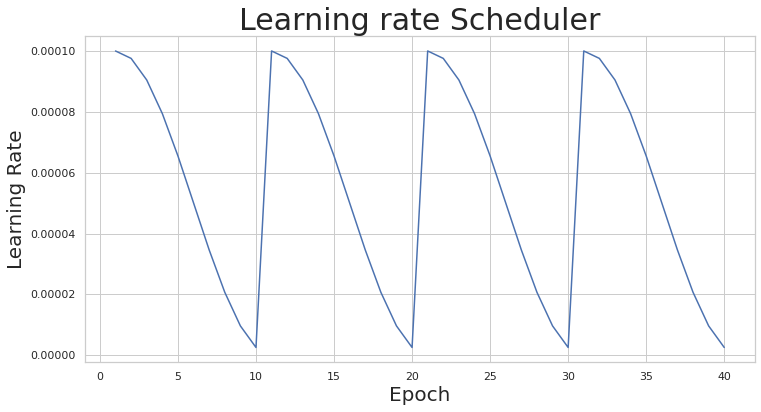

In [24]:
ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x = rang+1, y = y)
plt.title('Learning rate Scheduler', size=30)
plt.ylabel("Learning Rate", size=20);
plt.xlabel("Epoch", size=20);

In [25]:
clf_model = Sequential([feature_extractor,Dropout(0.1), global_average_layer, dense_layer, Dropout(0.1), softmax_layer])

In [26]:
clf_model.compile(optimizer = Adam(),
                  loss = CategoricalCrossentropy(),
                  metrics=['accuracy'])

In [27]:
clf_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 22,328,613
Trainable params: 22,294,181
Non-trainable params: 34,432
_______________________________________

In [28]:
validation_steps=20

loss0, accuracy0 = clf_model.evaluate(x = valid_generator, steps = validation_steps)

20/20 [==============================] - 7s 167ms/step - loss: 1.8223 - accuracy: 0.0765


In [29]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.80
initial accuracy: 0.08


In [30]:
early = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, verbose=0, mode='max', baseline=None, restore_best_weights=True)
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)
checkpoint = ModelCheckpoint(monitor='val_accuracy', filepath='weights_DNN.hdf5', mode='max', verbose=0, save_best_only=True)

callbacks_list = [lr_callback, checkpoint, early]

In [31]:
tf.keras.backend.clear_session()
history = clf_model.fit(train_generator,
                        validation_data = valid_generator,
                        epochs = EPOCHS,
                        callbacks=callbacks_list,
                        verbose = 1)

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(1e-04, shape=(), dtype=float32).
1204/1204 [==============================] - 391s 319ms/step - loss: 1.0085 - accuracy: 0.6615 - val_loss: 0.7605 - val_accuracy: 0.7397
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(9.755527e-05, shape=(), dtype=float32).
1204/1204 [==============================] - 381s 316ms/step - loss: 0.9260 - accuracy: 0.6913 - val_loss: 0.8019 - val_accuracy: 0.7192
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(9.0460395e-05, shape=(), dtype=float32).
1204/1204 [==============================] - 378s 314ms/step - loss: 0.8958 - accuracy: 0.7031 - val_loss: 0.5214 - val_accuracy: 0.8154
Epoch 4/40

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(7.9409874e-05, shape=(), dtype=float32).
1204/1204 [==============================] - 382s 317ms/step - loss: 0.8793 - accuracy: 0.7069 - val_l

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
df_acc = pd.melt(pd.DataFrame({'Train':acc, 'Validation':val_acc, 'Epoch':np.arange(1,len(val_acc)+1)}), 'Epoch')

loss = history.history['loss']
val_loss = history.history['val_loss']
df_loss = pd.melt(pd.DataFrame({'Train':loss, 'Validation':val_loss, 'Epoch':np.arange(1,len(val_loss)+1)}), 'Epoch')

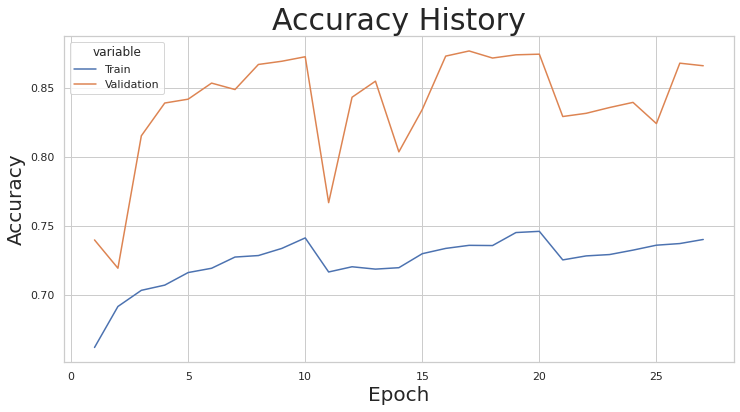

In [33]:
ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x = 'Epoch', y = 'value', hue='variable', data=df_acc);
plt.title('Accuracy History', size=30);
plt.ylabel("Accuracy", size=20);
plt.xlabel("Epoch", size=20);

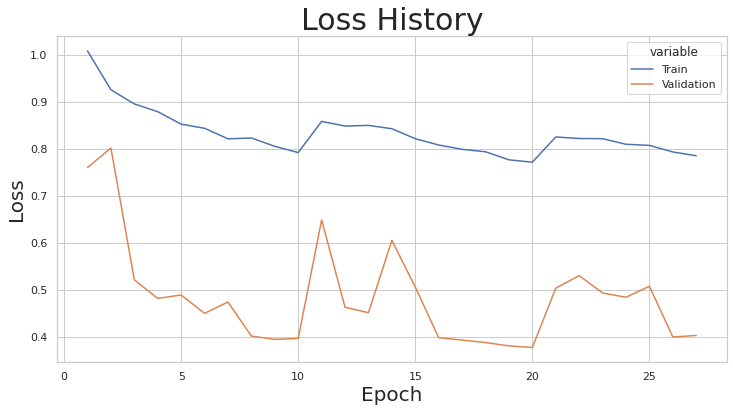

In [34]:
ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x='Epoch', y = 'value', hue='variable', data=df_loss);
plt.title('Loss History', size=30);
plt.ylabel("Loss", size=20);
plt.xlabel("Epoch", size=20);

# Prediction And Submission

In [35]:
sample_sub_csv = os.path.join(data_path, 'sample_submission.csv')
sample_sub_df = pd.read_csv(sample_sub_csv)
sample_sub_df.head()

,image_id,label
0,2216849948.jpg,4


In [36]:
clf_model.save('InceptionV3_Cassava_Full.h5')

In [37]:
test_aug = albumentations.Compose([albumentations.Resize(IMG_DIM, IMG_DIM, interpolation=1, p=1.),
                                   albumentations.Normalize(mean=[0.485, 0.456, 0.406], 
                                                            std=[0.229, 0.224, 0.225], 
                                                            max_pixel_value=255.0, 
                                                            p=1.0)],
                                  p=1.)

In [38]:
def predict(clf_model, img_id, data_path):
  test_img_path = os.path.join(data_path, 'test_images', img_id)
  test_img = cv2.imread(test_img_path)
  transformed_test = test_aug(image=test_img)
  transformed_image = transformed_test["image"]
  resized_img = cv2.resize(transformed_image, (IMG_DIM, IMG_DIM)).reshape(-1, IMG_DIM, IMG_DIM, 3)
  prediction = clf_model.predict(resized_img)
  return prediction

In [39]:
final_preds = None
for model in [clf_model]:
  for j in range(5):
    for img_id in sample_sub_df['image_id']:
        prediction = predict(clf_model, img_id, data_path)
        temp_preds = None
        for p in prediction:
            if temp_preds is None:
                temp_preds = p
            else:
                temp_preds = np.vstack((temp_preds, p))
        if final_preds is None:
            final_preds = temp_preds
        else:
            final_preds += temp_preds
final_preds /= (5*1)

In [40]:
preds = np.argmax(final_preds)

In [41]:
submission_file = pd.DataFrame({'image_id':list(sample_sub_df['image_id']),
                                'label':preds})
submission_file.head()

,image_id,label
0,2216849948.jpg,4
